In [1]:
%pylab inline
import pandas as pd
from hscictools import bnf,ccg,gbq # my local stuff

Populating the interactive namespace from numpy and matplotlib


# Chemical comparison at the county level

In order to try to get a big picture view of any geographic variation in prescribing data, it might be interesting to look at what each county spends on the chemicals which account for most spend nationally.

## Big Query

Let's load spend for each CCG on each chemical.

In [2]:
df=gbq.query(
    '''
    select BNF_CHEMICAL,PCT,sum(ACT_COST) TOTAL_ACT_COST
    from [nhs.PDPI2]
    where PERIOD contains "2015"
    group by BNF_CHEMICAL, PCT
    ''',
    max_rows=500000,
    index=['BNF_CHEMICAL','PCT'],cast={'TOTAL_ACT_COST':float},
    cachedir='/tmp/gbq'
)

Reading cached results from /tmp/gbq/42c0b627b5d645728652864c4610f7cf.json
375817 rows converted to DataFrame in 0.93 seconds


## CCG segmentation

The CCGs form two clusters. Let's keep only the cluster of CCGs prescribing the broader set of chemicals.

Keeping only those CCGs prescribing more than 100 checmicals, i.e. 212 CCGs, and 375817 rows


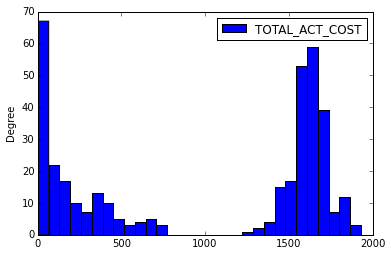

In [102]:
df.groupby(level=1).count().plot(kind='hist',bins=30)
chemsperccg=df.groupby(level=1).count()
ccgskeep=set(chemsperccg[chemsperccg['TOTAL_ACT_COST']>1000].index)
dfkeep=pd.DataFrame(df[df.index.map(lambda i:i[1] in ccgskeep and i[1] in ccg.ccgs())],copy=True)
print "Keeping only those CCGs prescribing more than 100 checmicals, i.e. %i CCGs, and %i rows" % (len(ccgskeep),len(df))

Let's also add in the counties (provided in the standard CGS refdata) and map the checmical codes into names.

In [103]:
dfkeep.index=pd.MultiIndex.from_tuples(dfkeep.index.map(lambda i: (bnf.description(i[0]),
                                                                   ccg.name(i[1]),
                                                                   ccg.county(i[1])
                                                                  )))
dfkeep.index.set_names(['BNF_CHEMICAL','CCG','COUNTY'],inplace=True)
dfkeep.head()

,,,TOTAL_ACT_COST
BNF_CHEMICAL,CCG,COUNTY,
Skin | Anti-Infective Skin Preparations | Antibacterial Preparations | Antibac'ial Preps Also Used Systemically | Fusidic Acid,NHS SOUTH EASTERN HAMPSHIRE CCG,HAMPSHIRE,5296.77
Skin | Anti-Infective Skin Preparations | Antifungal Preparations | Amorolfine Hydrochloride,NHS SOUTH EASTERN HAMPSHIRE CCG,HAMPSHIRE,4703.82
Appliances | Other Appliances,NHS SOUTH EASTERN HAMPSHIRE CCG,HAMPSHIRE,15729.46
Incontinence Appliances | Leg Bags,NHS SOUTH EASTERN HAMPSHIRE CCG,HAMPSHIRE,50380.00
Gastro-Intestinal System | Local Prepn for Anal & Rectal Disorders | Co Haemorrhoidal Prep's + Corticosteroid | Hydrocortisone,NHS SOUTH EASTERN HAMPSHIRE CCG,HAMPSHIRE,15981.07


## Cross tab for county and chemical

Here's the cross tab we want to visualise:

In [104]:
crosstab=dfkeep.groupby(level=(0,2)).sum()['TOTAL_ACT_COST'].unstack(0).fillna(0)
crosstab.head()

BNF_CHEMICAL,Anaesthesia | General Anaesthesia | Antagonists for Respiratory Depression | Flumazenil,Anaesthesia | General Anaesthesia | Anticholinesterases Used in Anaesthesia | Neostigmine Metilsulfate,Anaesthesia | General Anaesthesia | Antimuscarinic Drugs | Atropine Sulfate,Anaesthesia | General Anaesthesia | Antimuscarinic Drugs | Glycopyrronium Bromide,Anaesthesia | General Anaesthesia | Antimuscarinic Drugs | Hyoscine Hydrobromide,Anaesthesia | General Anaesthesia | Inhalational Anaesthetics | Nitrous Oxide,Anaesthesia | General Anaesthesia | Intravenous Anaesthetics | Etomidate,Anaesthesia | General Anaesthesia | Intravenous Anaesthetics | Ketamine,Anaesthesia | General Anaesthesia | Neuromuscular Blocking Drugs | Cisatracurium,Anaesthesia | General Anaesthesia | Sedative & Analgesic Peri-Operative Drgs | Benzodiazepines | Midazolam Hydrochloride,...,Stoma Appliances | Ileostomy Bags,Stoma Appliances | Ileostomy Sets,Stoma Appliances | Irrigation Washout Appliances,Stoma Appliances | Pressure Plates/Shields,Stoma Appliances | Skin Fillers And Protectives,Stoma Appliances | Skin Protectors,Stoma Appliances | Stoma Caps/Dressings,Stoma Appliances | Tubing & Accessories,Stoma Appliances | Two Piece Ostomy Systems,Stoma Appliances | Urostomy Bags
COUNTY,,,,,,,,,,,,,,,,,,,,,
AVON,0,0,14.19,1951.35,6523.84,0,0,0.00,0,20641.26,...,1025145.17,0,7191.86,396.36,438473.47,137546.59,13507.49,2325.02,213024.68,262888.85
BEDFORDSHIRE,0,0,0.00,4874.23,5755.73,0,0,283.97,0,6695.86,...,445489.68,0,7966.86,478.19,265769.57,76082.37,9189.66,259.22,178184.84,111826.87
BERKSHIRE,0,0,0.00,1008.21,323.93,0,0,2116.92,0,7805.91,...,680032.22,0,10160.36,355.25,224936.65,108685.12,5721.63,3111.36,266729.01,293213.78
BUCKINGHAMSHIRE,0,0,10.83,5394.70,673.93,0,0,43.09,0,7744.35,...,610938.31,0,9496.66,192.19,248973.94,76333.39,5671.33,1239.56,264471.23,175706.03
CAMBRIDGESHIRE,0,0,0.00,19180.78,55.26,0,0,356.92,0,11647.78,...,588580.82,0,12752.84,466.25,223158.81,80917.94,7565.16,1210.42,234606.54,209973.24


## Sort

Let's counties by total spend descending, and do the same for chemicals.

In [105]:
counties=dfkeep.groupby(level=2).sum().sort(columns=['TOTAL_ACT_COST'],ascending=False)
counties.head()

,TOTAL_ACT_COST
COUNTY,
LANCASHIRE,4.044685e+08
GREATER LONDON,3.733625e+08
WEST MIDLANDS,3.509958e+08
WEST YORKSHIRE,2.848336e+08
ESSEX,2.759957e+08


In [106]:
chemicals=dfkeep.groupby(level=0).sum().sort(columns=['TOTAL_ACT_COST'],ascending=False)
chemicals.head()

,TOTAL_ACT_COST
BNF_CHEMICAL,
Respiratory System | Corticosteroids (Respiratory) | Fluticasone Propionate (Inh),2.592915e+08
Central Nervous System | Antiepileptics | Control Of Epilepsy | Pregabalin,1.899452e+08
Nutrition And Blood | Oral Nutrition | Enteral Nutrition,1.739957e+08
Respiratory System | Bronchodilators | Antimuscarinic Bronchodilators | Tiotropium,1.329909e+08
Respiratory System | Corticosteroids (Respiratory) | Budesonide,1.315067e+08


## Truncate chemicals

We cannot hope to plot all the chemicals on a readable chart, so let's take the top N:

In [129]:
crosstab_sorted=crosstab.reindex(counties.index)[chemicals.index[:40]]
crosstab_sorted.head()

BNF_CHEMICAL,Respiratory System | Corticosteroids (Respiratory) | Fluticasone Propionate (Inh),Central Nervous System | Antiepileptics | Control Of Epilepsy | Pregabalin,Nutrition And Blood | Oral Nutrition | Enteral Nutrition,Respiratory System | Bronchodilators | Antimuscarinic Bronchodilators | Tiotropium,Respiratory System | Corticosteroids (Respiratory) | Budesonide,Endocrine System | Drugs Used In Diabetes | Diabetic Diagnostic & Monitoring Agents | Glucose Blood Testing Reagents,Respiratory System | Corticosteroids (Respiratory) | Beclometasone Dipropionate,Dressings | Wound Management & other Dressings,Endocrine System | Drugs Used In Diabetes | Antidiabetic Drugs | Biguanides | Metformin Hydrochloride,Appliances | Catheters,...,Central Nervous System | Analgesics | Opioid Analgesics | Oxycodone Hydrochloride,Central Nervous System | Analgesics | Opioid Analgesics | Fentanyl,Cardiovascular System | Lipid-Regulating Drugs | Atorvastatin,Central Nervous System | Analgesics | Opioid Analgesics | Tramadol Hydrochloride,Cardiovascular System | Lipid-Regulating Drugs | Ezetimibe,Endocrine System | Drugs Used In Diabetes | Insulin | Intermediate And Long-Acting Insulins | Biphasic Insulin Aspart,Central Nervous System | Antidepressant Drugs | Other Antidepressant Drugs | Venlafaxine,Cardiovascular System | Lipid-Regulating Drugs | Simvastatin,Cardiovascular System | Lipid-Regulating Drugs | Rosuvastatin Calcium,Skin | Preparations For Eczema And Psoriasis | Preparations For Psoriasis | Calcipotriol
COUNTY,,,,,,,,,,,,,,,,,,,,,
LANCASHIRE,17842568.09,13929420.20,12618257.06,9982481.31,9076420.08,7060517.52,6513387.27,6128793.82,5142408.02,3937651.44,...,3770485.55,2938696.97,2322614.84,3313523.38,2210398.09,1971689.81,2153843.29,2198552.01,1917220.79,2227886.50
GREATER LONDON,12823333.29,11228140.51,11595215.13,6668479.71,7590746.32,8167360.01,4790484.36,5270508.53,7206059.46,3332936.62,...,1593664.99,1648918.59,2590977.87,1620256.72,2312861.13,2566893.08,1712046.95,1849721.03,1854184.76,2159536.82
WEST MIDLANDS,16637602.93,10418745.70,13382850.48,6622242.41,5789716.74,6897379.28,5010266.58,5930617.15,5503860.46,3406869.35,...,1657177.32,1932331.43,2020480.23,2606156.62,2325738.27,3268308.45,1898163.63,2049207.29,1782734.63,1919824.94
WEST YORKSHIRE,14316933.82,8393137.81,8420390.88,6201399.03,5511232.87,5515468.02,3854661.90,5139327.46,3703789.71,3317022.74,...,2039788.48,1935040.16,1847713.42,2107381.34,1407323.94,1333172.60,1219527.17,1387854.19,1596332.22,1421705.50
ESSEX,12953478.86,10714245.92,7142280.62,5939482.97,4647831.94,5369399.02,3686607.59,3854082.29,4022747.81,3271078.96,...,1574294.68,2216166.67,1907889.50,1434570.24,1293407.89,1511966.07,1443527.53,1510910.21,1333016.30,1338749.26


## Plot

Finally, we can plot.

X-axis labelling is held back until the very last plot.

Each county has an independent scale on the y-axis.

The idea is to visually compare the shape of the bar progression across counties.

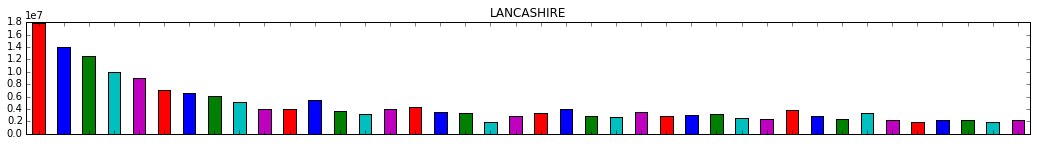

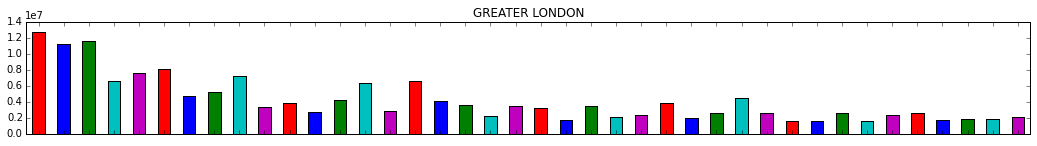

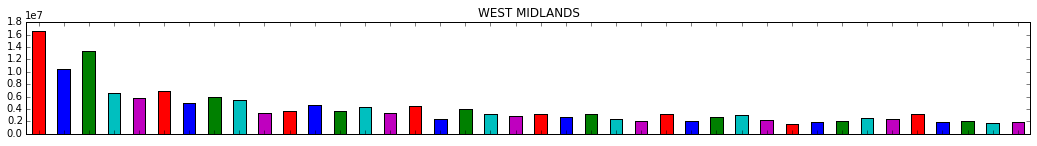

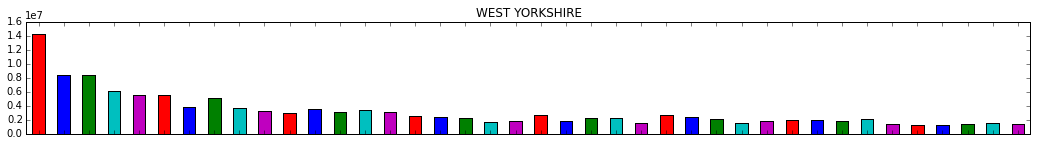

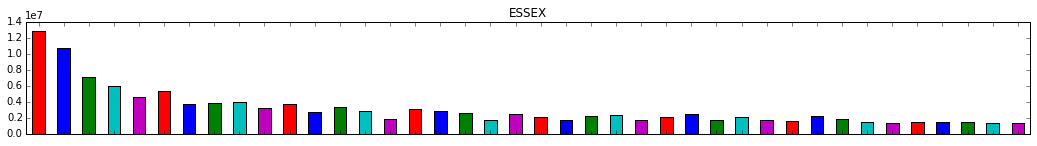

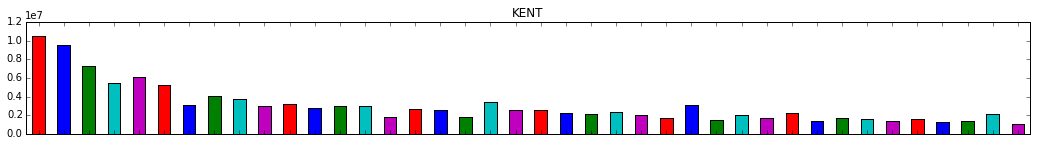

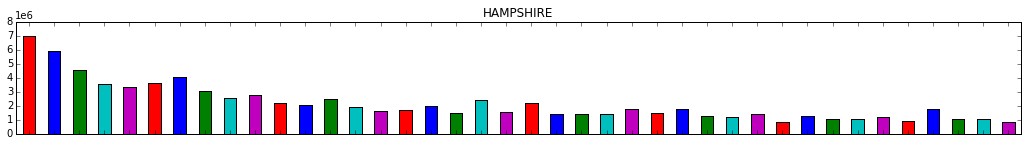

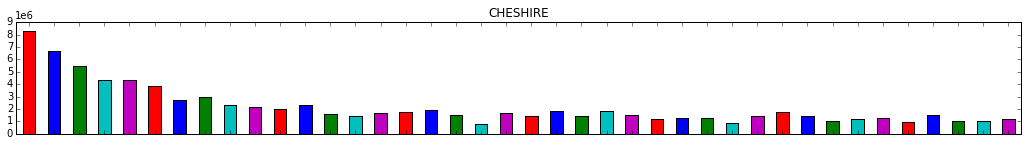

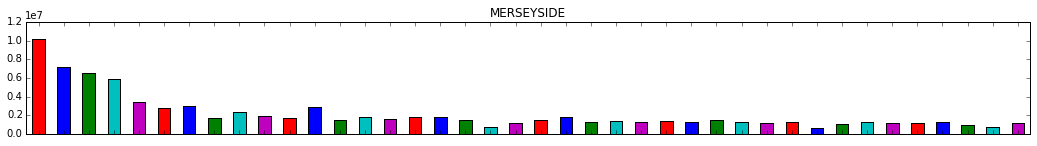

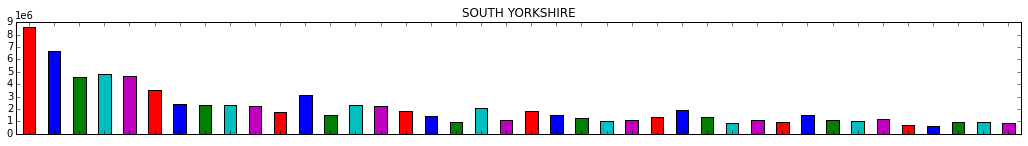

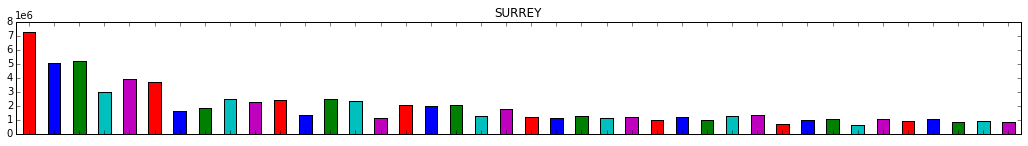

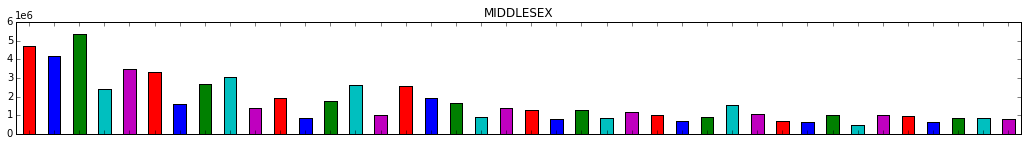

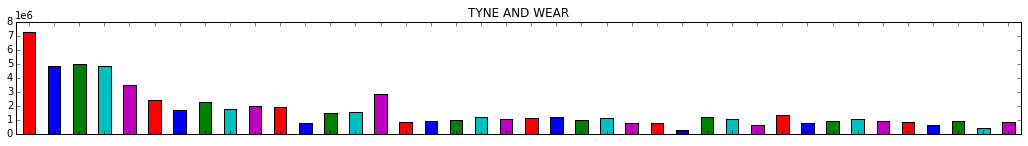

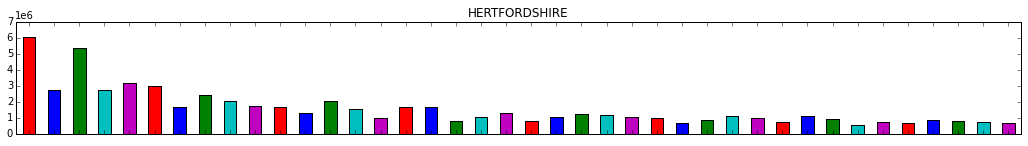

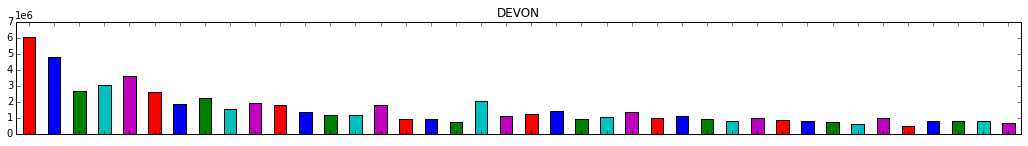

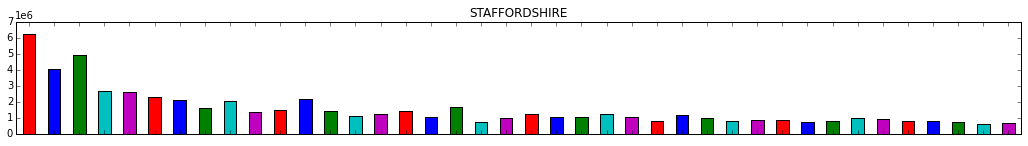

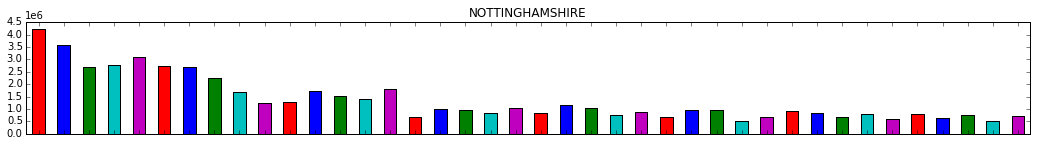

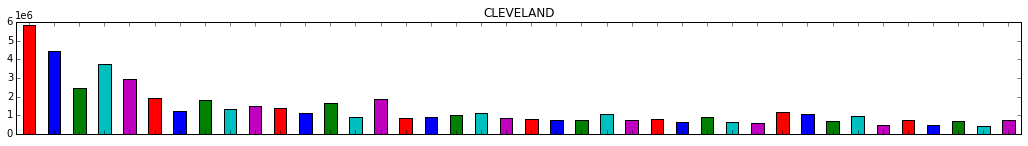

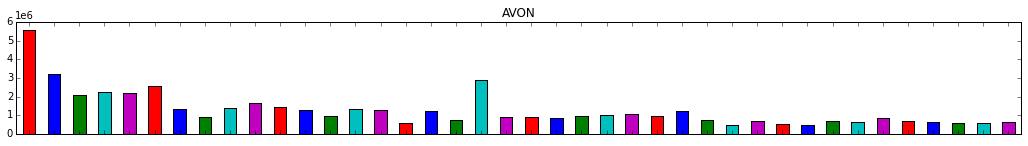

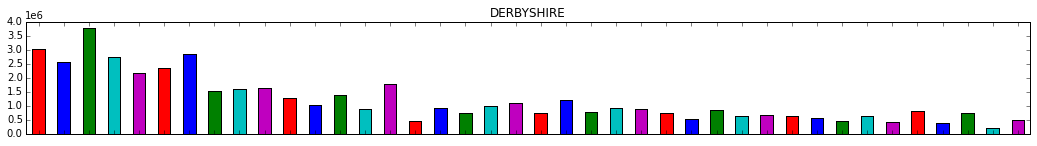

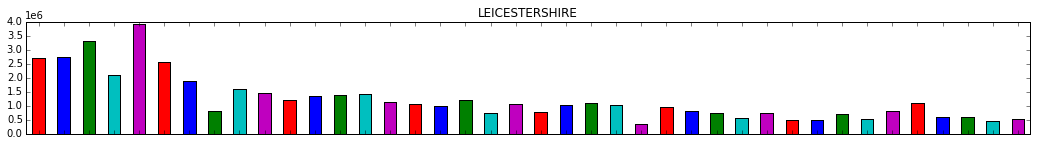

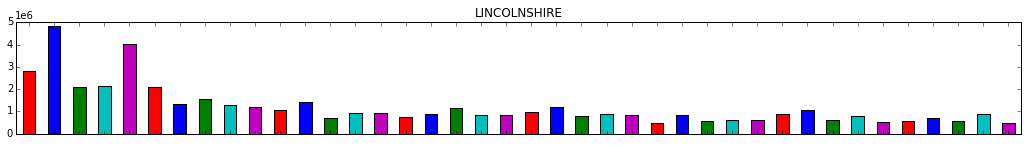

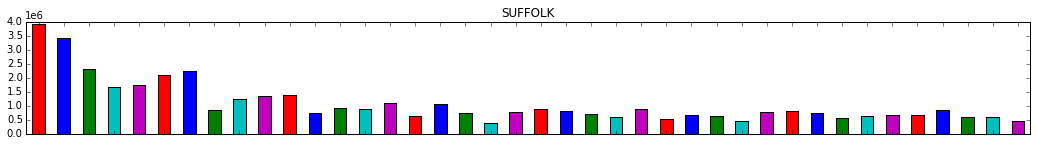

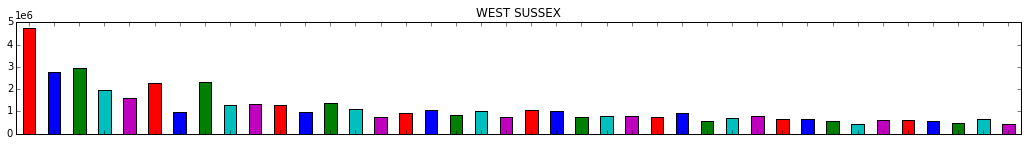

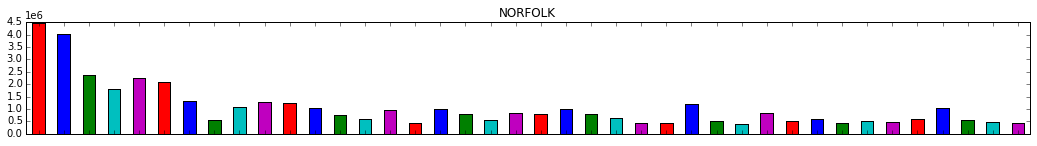

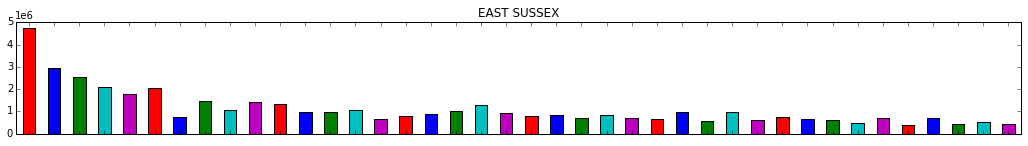

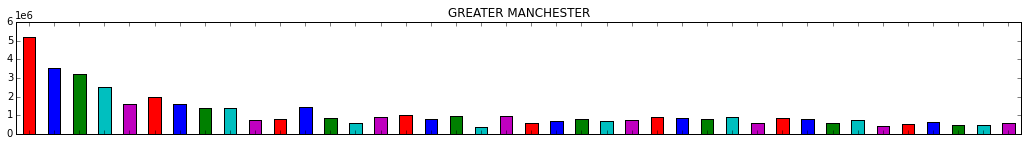

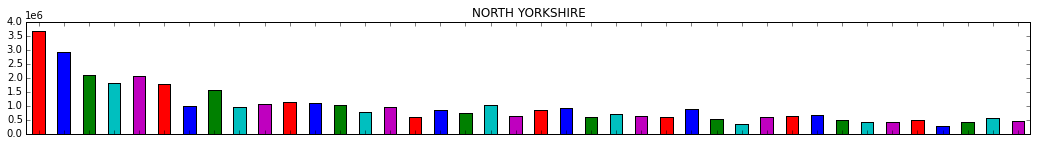

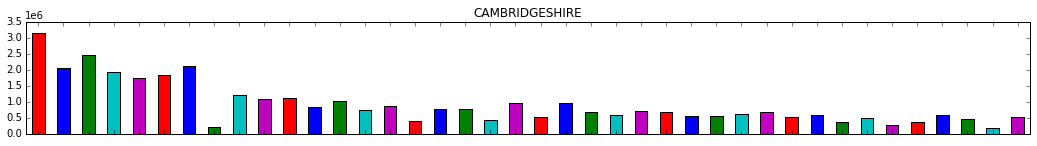

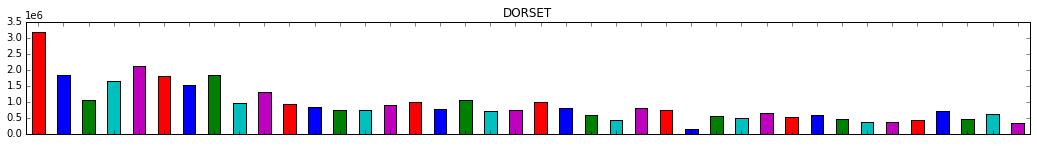

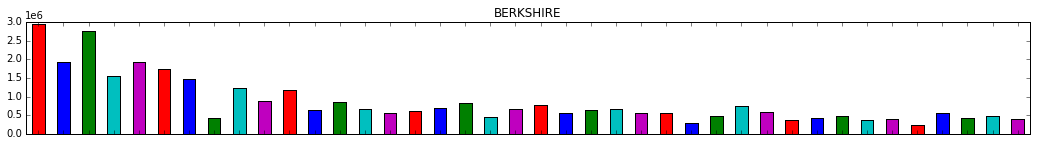

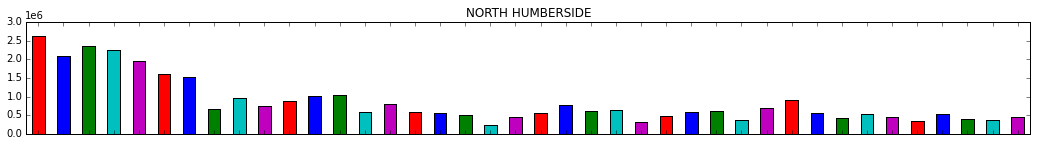

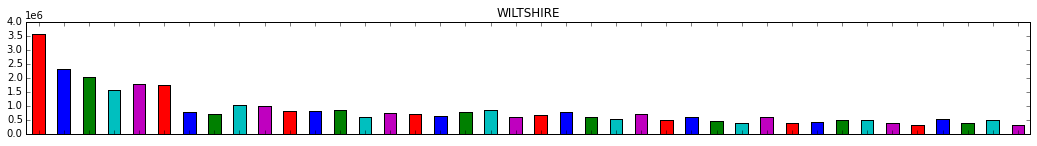

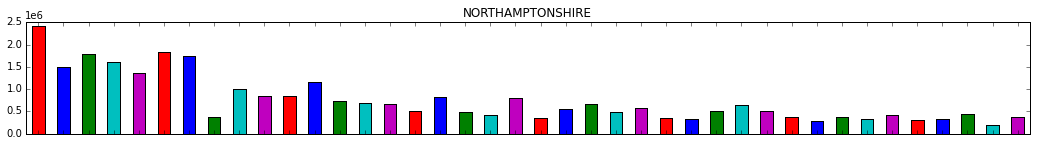

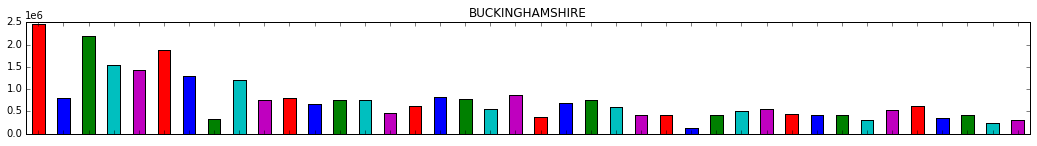

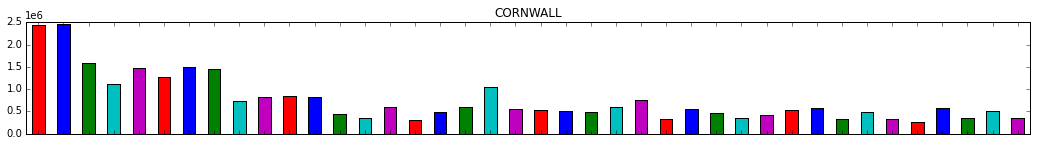

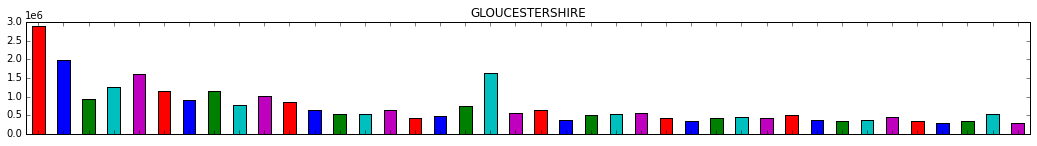

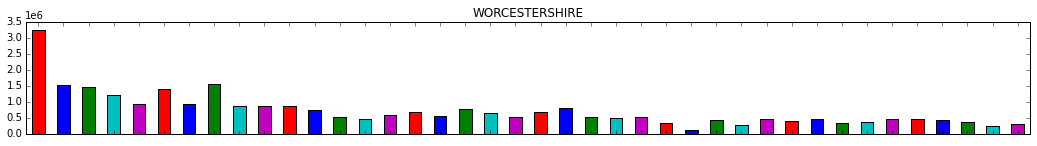

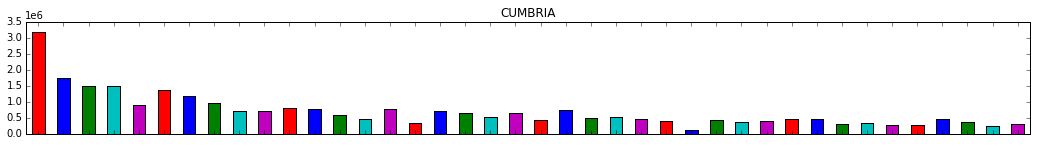

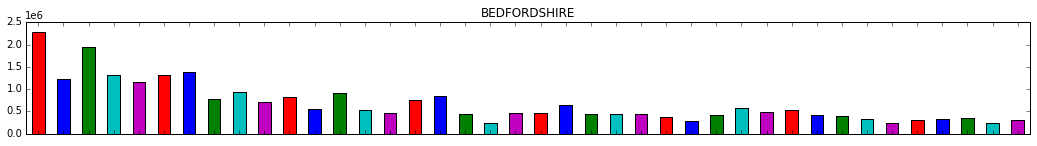

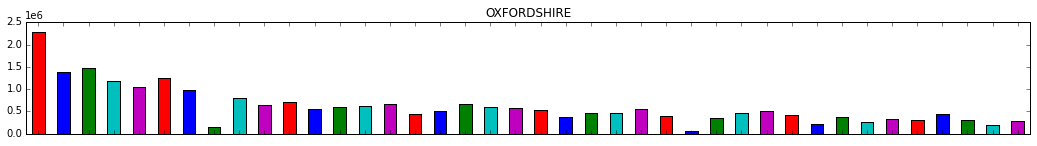

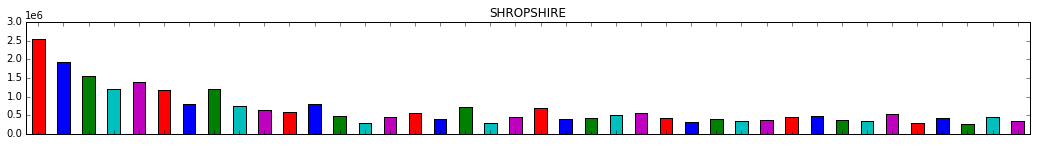

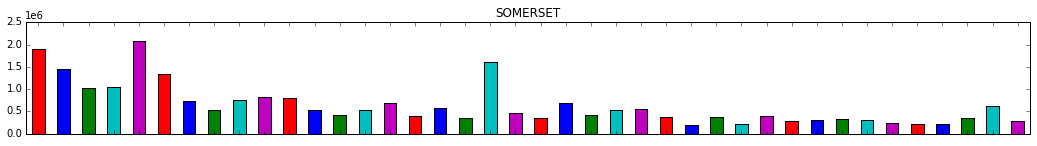

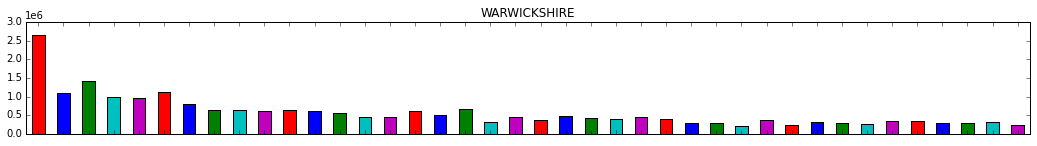

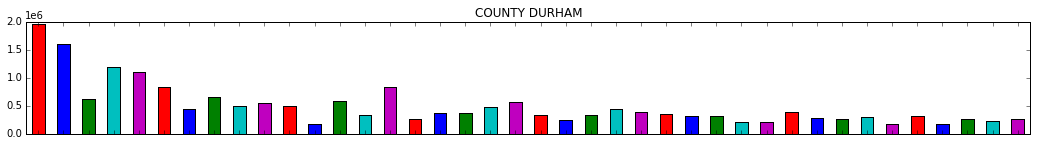

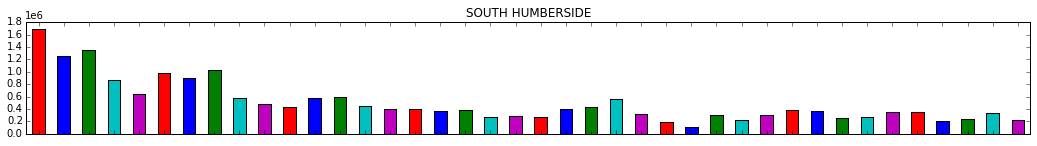

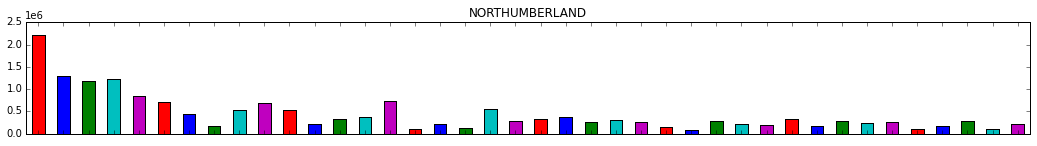

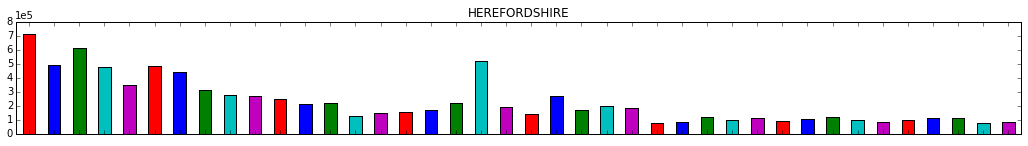

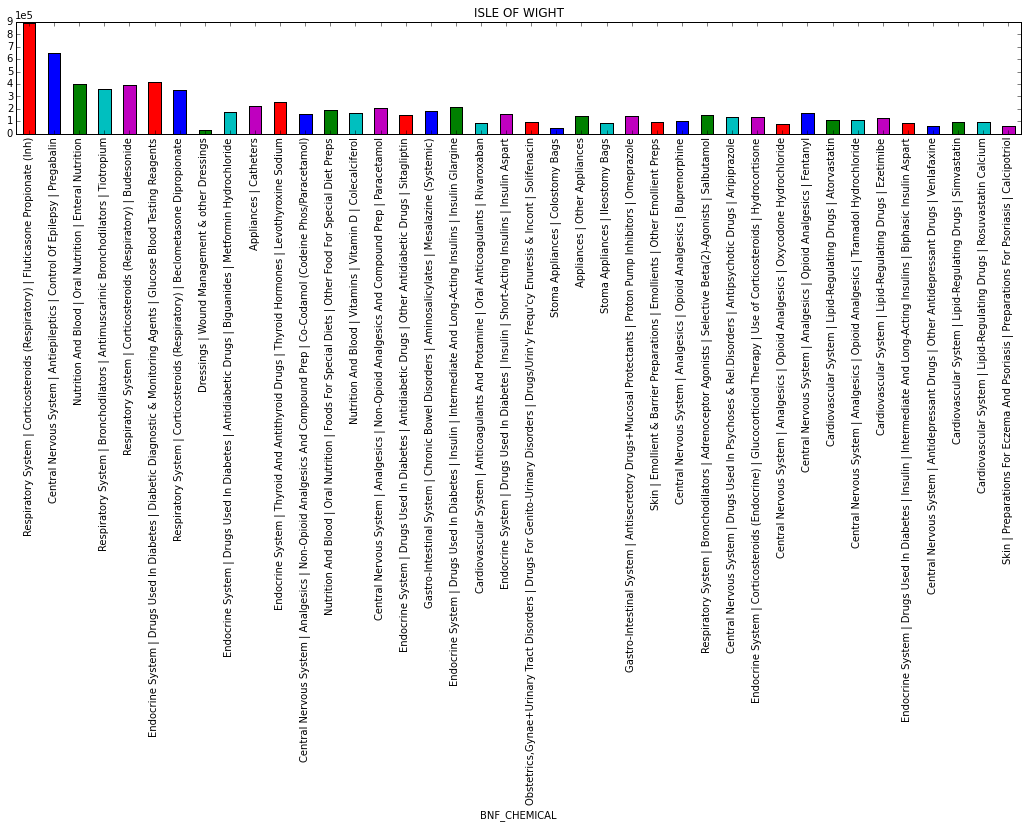

In [130]:
n=min(50,len(crosstab_sorted))
for i,county in enumerate(crosstab_sorted.index[:n]):
    ax=crosstab_sorted.ix[county].plot(kind='bar',figsize=(18,2),title=county,color='rbgcm')
    if i<n-1: # only plot x labels on the bottom plot
        ax.set_xlabel('')
        ax.set_xticklabels(['' for item in ax.get_xticklabels()])
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    show()
    